# Magic BERT
#### Investigating the similarity of MtG flavor text with a large language model

We will be using the [Sentence-BERT](https://arxiv.org/abs/1908.10084) (SBERT) model, which has been pretrained and optimized for finding similarities in text. It is designed to provide meaningful embeddings of sentences such that outputs with low cosine distance will have very similar semantic content. To do so we will create a sentence-transformer using the [all-mpnet-base-v2](https://huggingface.co/sentence-transformers/all-mpnet-base-v2) model, which according to the experts at [SBERT](https://www.sbert.net/docs/sentence_transformer/pretrained_models.html#original-models) has the highest performance on these types of tasks.

---

This notebook is based off of the [NLP Course](https://huggingface.co/learn/nlp-course/en) from HuggingFace and [this Geeks for Geeks post](https://www.geeksforgeeks.org/sentence-similarity-using-bert-transformer/).


In [3]:
import numpy as np
import torch

# Create Model Object
from sentence_transformers import SentenceTransformer
# device = torch.device("mps")
model = SentenceTransformer("all-mpnet-base-v2",device='mps')

Let's make up some flavor text! We will then run it through our model to see which are the most similar. 
Here I am writing two sentences about goblins and their odor, which should have a high similarity metric. The other two sentences are meant to sound like generic flavor text from Blue or Black cards, and should be dissimilar to each other and the two lines about Goblins. 

In [4]:
my_flavor_text = ["Goblins sure do smell bad.",
    "Those goblins are loud and offensive!",
    "The mind is the purest distillation of progress.",
    "My power over death makes me unstoppable"]

In [5]:
# By default the model uses Cosine Similarity as the similarity metric.
embeddings = model.encode(my_flavor_text)
similarities = model.similarity(embeddings,embeddings)
print(similarities)

tensor([[ 1.0000,  0.6725,  0.0113,  0.0721],
        [ 0.6725,  1.0000, -0.0032,  0.1065],
        [ 0.0113, -0.0032,  1.0000,  0.2725],
        [ 0.0721,  0.1065,  0.2725,  1.0000]])


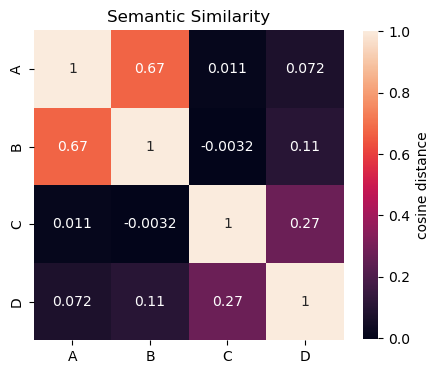

In [6]:
# Next we can visualize the similarities with a heat map matrix using Seaborn
import seaborn as sns
from matplotlib import pyplot as plt

labels = ['A','B','C','D']
fig, ax = plt.subplots(figsize=(5,5))
sns.heatmap(similarities, annot=True,
            xticklabels=labels,yticklabels=labels,
            square=True,cbar_kws={'shrink':0.8,'label':'cosine distance'})
plt.title('Semantic Similarity')
plt.show(block=False)

As expected, the first two lines of text are very similar to eachother, while the remaining two are relatively dissimilar.

## Now, let's take a look at actual flavor text! 

Our hypothesis is that red cards will be most similar to other red cards, blue cards similar to other blue cards, and so forth.
To reduce computation time and simplify visualization, we will start with 500 cards: 100 monocolored cards from each of the five colors. 

In [8]:
# Load card data
import pickle
import pandas as pd
datapath = 'card_data/CardData.pkl'
with open(datapath,'rb') as file:    
    data = pickle.load(file)

# Simplify dataframe to relevant information
data = data.loc[:,['name','type_line','set','mana_cost','colors','flavor_text']].reset_index(drop=True)

# Identify monocolored cards
is_monocolored = data['colors'].apply(lambda x : np.shape(x) == (1,))
data['monocolored'] = is_monocolored

In [9]:
# Subset 100 random monocolored cards from each color
# Set a random seed for replicability:
np.random.seed(31)
colors = ['W','U','B','R','G']
mono_cards = data.loc[data['monocolored'],:]

card_subsample = pd.concat([mono_cards.loc[mono_cards['colors'].explode() == color,:].sample(100) for color in colors])
card_subsample = card_subsample.reset_index(drop=True)
print('Some example monocolored cards')
card_subsample.sample(10)

Some example monocolored cards


,name,type_line,set,mana_cost,colors,flavor_text,monocolored
312,Lightning Bolt,Instant,prm,{R},[R],"""my, how shocking.""\n—barrin, tolarian archmage",True
375,Smelt,Instant,m13,{R},[R],"""looks like that wasn't darksteel after all.""\...",True
445,Deadbridge Goliath,Creature — Insect,j22,{2}{G}{G},[G],some golgari insects live for centuries—and th...,True
254,Demon of Death's Gate,Creature — Demon,m11,{6}{B}{B}{B},[B],the locks on the cages of the damned are opene...,True
473,Elvish Piper,Creature — Elf Shaman,ltc,{3}{G},[G],"""in dwimordene, in lórien\nseldom have walked ...",True
202,Spiteful Hexmage,Creature — Human Warlock,pwoe,{B},[B],"""who'll never amount to anything now, father?""",True
197,Ithilien Kingfisher,Creature — Bird,ltr,{2}{U},[U],"after their reunion, the hobbits spent many da...",True
145,Precognition,Enchantment,tmp,{4}{U},[U],a gleam like struggling sunlight penetrated se...,True
189,"Drafna, Founder of Lat-Nam",Legendary Creature — Human Artificer Advisor,pbro,{1}{U},[U],"alongside his wife, hurkyl, drafna built a leg...",True
49,Swords to Plowshares,Instant,drc,{W},[W],"""i do not wish for a return of the old gods, n...",True


In [10]:
# Extract the flavor text column from our data frame and run it through our model
flavor_text_sample = card_subsample['flavor_text'].to_numpy()
embeddings = model.encode(flavor_text_sample)
similarities = model.similarity(embeddings,embeddings)


In [27]:
card_subsample['embedding'] = list(embeddings)

,name,type_line,set,mana_cost,colors,flavor_text,monocolored,W_mean_similarity,U_mean_similarity,B_mean_similarity,R_mean_similarity,G_mean_similarity,embedding
0,Dutiful Servants,Creature — Zombie,hou,{3}{W},[W],buildings crumbled and monuments fell. the riv...,True,0.214294,0.194092,0.230958,0.217231,0.219085,"[-0.032699842, 0.08691005, -0.029150248, 0.017..."
1,Marble Gargoyle,Artifact Creature — Gargoyle,mh2,{2}{W},[W],"""once past the stony exterior, the meat is exq...",True,0.170353,0.175898,0.214811,0.195235,0.197247,"[0.023826353, -0.002049826, -0.020407515, 0.00..."
2,Parapet,Enchantment,vis,{1}{W},[W],there is no wall that can't be improved by mak...,True,0.100140,0.094001,0.079083,0.105685,0.115277,"[-0.053040504, 0.11786568, 0.001696698, 0.0108..."
3,Exquisite Archangel,Creature — Angel,paer,{5}{W}{W},[W],a living invention born of a grand design.,True,0.120039,0.135162,0.102458,0.105160,0.135593,"[0.020904522, -0.034725863, -0.0077477093, -0...."
4,Allied Assault,Instant,znr,{2}{W},[W],a common foe is the death of old hatreds.,True,0.206982,0.178583,0.239855,0.205651,0.198393,"[0.03002137, 0.07946132, 0.010342194, -0.00814..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...
495,Cystbearer,Creature — Phyrexian Beast,som,{2}{G},[G],"phyrexia strives to simulate natural life, but...",True,0.094974,0.114812,0.107878,0.102428,0.144118,"[0.040967744, 0.008383315, -0.0067554214, 0.01..."
496,Natural Spring,Sorcery,tmp,{3}{G}{G},[G],"mirri listened intently, even as hanna held th...",True,0.147579,0.163522,0.145468,0.133028,0.152985,"[-0.025600486, -0.013098674, -0.054534208, 0.0..."
497,Greenhilt Trainee,Creature — Elf Warrior,nph,{3}{G},[G],"""our ancestors adapted to this world of metal....",True,0.281311,0.257798,0.272783,0.279569,0.239380,"[0.03398709, 0.04672272, -0.024571735, -0.0371..."
498,Urban Daggertooth,Creature — Dinosaur,mh2,{2}{G}{G},[G],"stop, smell the roses, eat the peoples.",True,0.137195,0.120784,0.153461,0.147813,0.165346,"[0.022749824, 0.17111862, -0.0026742753, 0.040..."


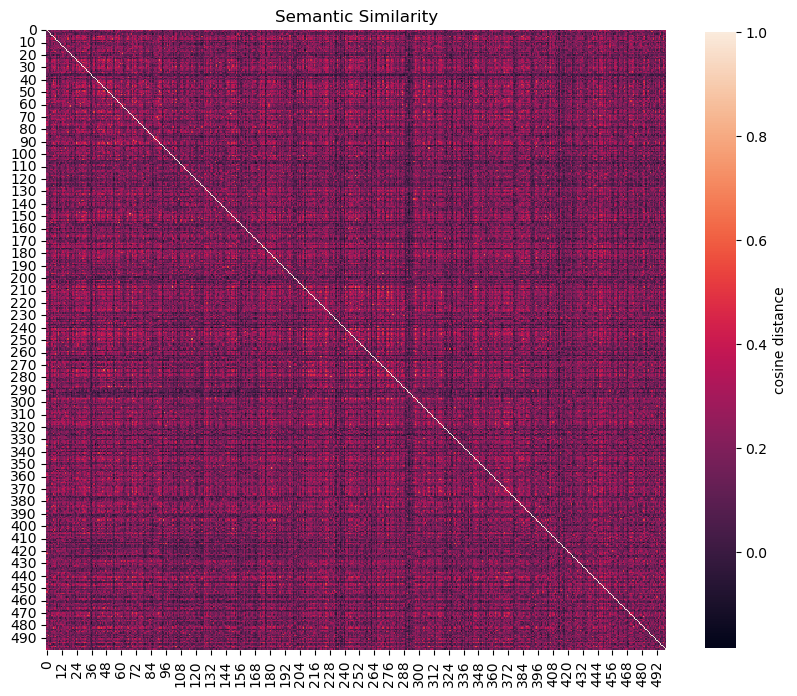

In [11]:
fig, ax = plt.subplots(figsize=(10,10))
sns.heatmap(similarities, annot=False,
            square=True,cbar_kws={'shrink':0.8,'label':'cosine distance'})
plt.title('Semantic Similarity')
plt.show(block=False)

Despite putting the flavor text in order of color, there doesn't seem to be any underlying structure. 

Let's take a closer look at which cards are most and least similar

In [12]:
sim_np = similarities.numpy() # from tensor to np array
np.fill_diagonal(sim_np,0)
# Fill the upper triangle of the matrix with zeros so we don't get repeated pairs
sim_np = np.tril(sim_np)

In [13]:
# Look for the top 10 most similar pairs of text:
# Unravel similarities
sim_np_unravel = sim_np.reshape(-1)
x,y = np.unravel_index(np.argpartition(sim_np_unravel,-10),sim_np.shape)
# each x-y pair corresponds to a pair of flavor texts. 
# Iterate through them and print out each pair along with their similarity scores
# (Note that the scores are unsorted, but last 10 are guaranteed to be the top 10 highest scores)
x_top = x[-10:]
y_top = y[-10:]
for i in range(len(x_top)):
    sim_score = float(sim_np[x_top[i]][y_top[i]])
    print(f"Similarity Score = {np.round(sim_score,3)}")
    print(card_subsample['name'][x_top[i]])
    print("   ",flavor_text_sample[x_top[i]])
    print("")
    print(card_subsample['name'][y_top[i]])
    print("   ",flavor_text_sample[y_top[i]])
    print(" ")
    print('--------')

Similarity Score = 0.65
Pious Interdiction
    "ours is the true and righteous path. you will bow before our might."

Swords to Plowshares
    "i do not wish for a return of the old gods, nor to recapture the glory of the past. i only wish to see my people thrive. that is enough."
 
--------
Similarity Score = 0.651
Ultimate Price
    "the realization that one is dying is far more terrifying than death itself."
—sidisi, silumgar vizier

Bloodline Necromancer
    "the veil of death hides little from our kind."
 
--------
Similarity Score = 0.658
Elvish Harbinger
    "the mirror of galadriel shows things that were, and things that are, and things that yet may be."

Elvish Piper
    "in dwimordene, in lórien
seldom have walked the feet of men,
few mortal eyes have seen the light
that lies there ever, long and bright.
galadriel! galadriel!"
 
--------
Similarity Score = 0.659
Slagstorm
    "as long as we have the will to fight, we are never without weapons."
—koth of the hammer

Ironclad S

These seem to mesh relatively well with eachother. Now let's take a look at the lowest scores and see if they look wildly different:

In [15]:
# First replace all 0's with 1's so that we can still ignore the diagonal and upper triangle
sim_np[sim_np == 0] = 1
x,y = np.unravel_index(np.argpartition(sim_np_unravel,5),sim_np.shape)
sim_np_unravel = sim_np.reshape(-1)
x_top = x[:5]
y_top = y[:5]
for i in range(len(x_top)):
    sim_score = float(sim_np[x_top[i]][y_top[i]])
    print(f"Similarity Score = {np.round(sim_score,3)}")
    print(card_subsample['name'][x_top[i]])
    print("   ",flavor_text_sample[x_top[i]])
    print("")
    print(card_subsample['name'][y_top[i]])
    print("   ",flavor_text_sample[y_top[i]])
    print(" ")
    print('--------')

Similarity Score = -0.183
Nuclear Fallout
    the end of the world occurred as predicted: too many humans, not enough space or resources to go around. the details are trivial and pointless. the reasons, as always, purely human ones.

Swarm of Bloodflies
    in the gudul delta, bloodfly bites are indistinguishable from spear wounds.
 
--------
Similarity Score = -0.162
Witch's Cauldron
    the best recipes start with reliable cookware.

Wing It
    after a moment's confusion, the otter splashed through clouds and gamboled in the wind, delighting in its newfound freedom.
 
--------
Similarity Score = -0.156
Cleaver Riot
    measure once, cut twice.

Marauding Boneslasher
    with the hekma destroyed, the wandering dead that sought entrance to naktamun had free rein to lay waste to the city.
 
--------
Similarity Score = -0.154
Kobold Taskmaster
    the taskmaster knows that there is no cure for the common kobold.

Wing It
    after a moment's confusion, the otter splashed through clouds 

While it is difficult to say if these pairs are truly *disparate* in some way, they certainly different vibes than those flavor text pairs that are most similar.

### Comparing cards by their relationship to all cards in a color

From our previous matrix, it is difficult to say how similar cards within a color are to eachother compared to other colors. Here we will measure that explicitly by taking the average similarity of each card to each other card, broken down by color.

In [16]:
# Reset the similarity matrix so we no longer ignore the upper triangle:
sim_np = similarities.numpy() # from tensor to np array
color_vect = card_subsample.colors.to_numpy()

for i in card_subsample.index:
    for c in colors:
        color_inds = card_subsample.loc[card_subsample.colors.explode() == c,:].index
        color_inds = color_inds[color_inds != i]
        color_similarities = sim_np[i,color_inds]
        color_sim_mean = np.mean(color_similarities)
        column_name = c[0]+"_mean_similarity"
        card_subsample.loc[i,column_name] = color_sim_mean

In [17]:
card_subsample.sample(10)

,name,type_line,set,mana_cost,colors,flavor_text,monocolored,W_mean_similarity,U_mean_similarity,B_mean_similarity,R_mean_similarity,G_mean_similarity
476,Skalla Wolf,Creature — Wolf Spirit,m19,{3}{G}{G},[G],"""this imprint was the familiar of a friend.""\n...",True,0.231521,0.239682,0.210577,0.206948,0.191064
232,Blightbeetle,Creature — Insect,m20,{1}{B},[B],leaf and soul alike wither at its touch.,True,0.168589,0.166407,0.213486,0.169899,0.227638
43,Narrow Escape,Instant,dde,{2}{W},[W],"he could find no strength left to budge, no po...",True,0.211134,0.165065,0.207035,0.203556,0.179064
490,Grappler Spider,Creature — Spider,wwk,{1}{G},[G],creatures of the air wisely avoid the darkest ...,True,0.111910,0.092168,0.113300,0.124883,0.145613
93,Trapped in the Screen,Enchantment,dsk,{2}{W},[W],maggie had always wanted to be on television.,True,0.048543,0.049819,0.035235,0.040231,0.047275
29,Venerable Monk,Creature — Human Monk Cleric,7ed,{2}{W},[W],"""i rely not so much on the wisdom of age as on...",True,0.231467,0.235636,0.194806,0.212197,0.185538
102,Steamcore Scholar,Creature — Weird Detective,mkm,{2}{U},[U],"""hm. that's weird.""",True,0.101284,0.136623,0.104984,0.114505,0.091292
131,Get Out,Instant,dsk,{U}{U},[U],kaito's blade brought the light of another pla...,True,0.155028,0.127329,0.143559,0.128095,0.132078
332,Pardic Miner,Creature — Dwarf,ody,{1}{R},[R],"""punch and drag, toss the slag, sift the soil,...",True,0.219868,0.209111,0.218111,0.237811,0.227213
421,Noble Hierarch,Creature — Human Druid,j12,{G},[G],"she protects the sacred groves from blight, dr...",True,0.175757,0.131321,0.156348,0.153484,0.199818


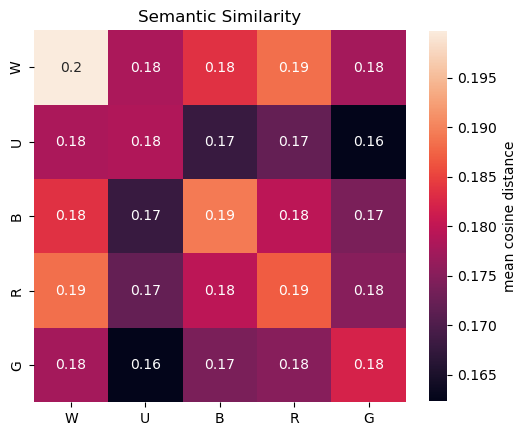

In [18]:
color_similarity_df = card_subsample.loc[:,['colors','W_mean_similarity','U_mean_similarity','B_mean_similarity','R_mean_similarity','G_mean_similarity']]
color_similarity_df['colors'] = color_similarity_df['colors'].explode()
color_similarity_df = color_similarity_df.groupby('colors').mean()
# Put back in WUBRG order:
color_similarity_df = color_similarity_df.loc[['W','U','B','R','G'],:]
# Make a heatmap
fig, ax = plt.subplots(figsize=(6,6))
sns.heatmap(color_similarity_df.values, annot=True,
            xticklabels = colors,yticklabels=colors,
            square=True,cbar_kws={'shrink':0.8,'label':'mean cosine distance'})
plt.title('Semantic Similarity')
plt.show(block=False)

Overall there is very little variation in cosine similarity as a function of color. 

### Are there other aspects of a card's design that better explain its similarity in flavor to other cards? We can investigate this with clustering techniques

We are assuming that there are 5 true clusters in our data corresponding to the different colors (though that doesn't appear to be the case). First, let's cluster using k-means and see what 5 clusters pop out. 

In [28]:
from sklearn.cluster import KMeans
